# EEGNet

In [21]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import mne
from tensorflow.keras.utils import to_categorical

2023-06-06 14:36:32.755545: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


## Prepare data for EEGNet

From our download dataset we epoched the interested events into (-0.5, 0.5) time window and resample it into 150Hz, we also selected the first 60 channels in order to convert it into `X`, `y` format so it is compatible with the EEGNet architecture. For each subject, we have `X_i` and `Y_i` that we will then combine it into a single `X` matrix and `y` label vector. 

In [24]:
from dataclasses import dataclass

@dataclass
class Dataset():
    name: str
    data_path: str
    export_path: str
    sub_number : int

In [25]:
imagine_emotion = Dataset('Imagine Emotion', './dataset/', './processed_data/', 35)

In [26]:
class PrepareData:
    def __init__(self, dataset, epoch_window=(-0.5, 0.5), sfreq=150, chans=60) -> None:
        self.data_path = dataset.data_path
        self.export_path = dataset.export_path
        self.emotions = {
            "anger",
            "awe",
            "compassion",
            "content",
            "disgust",
            "excite",
            "fear",
            "frustration",
            "grief",
            "happy",
            "jealousy",
            "joy",
            "love",
            "relief",
            "sad",
        }
        self.selected_annotations = {
            "press", 
            "press1"
        }
        self.positive_emotions = [
            'awe', 
            'joy',
            'happy', 
            'love', 
            'compassion', 
            'content', 
            'relief', 
            'excite',
        ]
        self.sub_numbers = dataset.sub_number
        self.tmin = epoch_window[0]
        self.tmax = epoch_window[1]
        self.sfreq = sfreq
        self.chans = chans

    def run(self):
        self.convert_all_files()
            
    def _rename_press_events(self, raw: mne.io.Raw) -> None:
        annotations = raw.annotations

        # Modify annotation names, to add information about
        # the emotion

        idx = 0
        while idx < len(annotations):
            desc = annotations.description[idx]
            if desc in self.emotions:
                j = idx + 1
                while annotations.description[j] in self.selected_annotations:
                    annotations.description[j] = f"{annotations.description[j]}_{desc}"
                    j += 1
                idx = j
            else:
                idx += 1

        # Update the annotations
        raw.set_annotations(annotations)
    

    def _reversed_labels(self, epochs, event_id):
        event_id_reverse = {v: k.split('_')[-1] for k, v in event_id.items()}  
        return [
            event_id_reverse[label] for label in epochs.events[:, -1]
        ]
         
    
    def _get_binary_labels(self, epochs, event_id ):
        return np.array([1 if label in self.positive_emotions else 0
                         for label in self._reversed_labels(epochs, event_id)])

    def set_to_df(
        self,
        raw_path,
        filename,
        initial_epoch_id=0,
    ) -> int:
        """
        Convert a single .set file to X and y and save it to numpy
        Returns the ID of the last epoch created.
        """
        raw = mne.io.read_raw_eeglab(raw_path, preload=True, montage_units='m')
        self._rename_press_events(raw)
        events, event_id = mne.events_from_annotations(
            raw=raw, regexp="|".join(self.selected_annotations)
        )
        epochs = mne.Epochs(
            raw,
            events=events,
            event_id=event_id,
            tmin=self.tmin,
            tmax=self.tmax,
            baseline=(self.tmin, 0),
            preload=True
        )
        epochs.resample(self.sfreq)

        X = epochs.get_data()
        y = self._get_binary_labels(epochs,event_id)
        
        X = np.array(X[:,:self.chans])
        y = to_categorical(y, num_classes=2)
        filename = self.export_path + filename

        np.save(filename+'_X', X)
        np.save(filename+'_Y', y)


    def convert_all_files(self):
        """
        Convert all files from EEGLAB into numpy format in order to
        facilitate further modeling tasks
        """
        dataset_directory_path = self.data_path
        initial_epoch_id = 0

        for i in range(1, self.sub_numbers + 1):
            try:
                raw_path = (
                    dataset_directory_path
                    + f"sub-{i:02d}/eeg/sub-{i:02d}_task-ImaginedEmotion_eeg.set"
                )
                filename = f"sub-{i:02d}"
                self.set_to_df(
                    raw_path, filename, initial_epoch_id=initial_epoch_id
                ) 
            except (
                RuntimeError, 
                TypeError, 
                NameError, 
                FileNotFoundError, 
                ValueError,
                ):
                print(f"Encountered an error while loading sub-{i:02d}'s file")
                

In [28]:
%%capture prepare_data
PrepareData(imagine_emotion, epoch_window=(-0.5, 0.5), sfreq=150, chans=60).run()

### Combining subject data into X, Y 

In [72]:
processed_path = './processed_data/'
X_files = [ f"sub-{i:02d}_X.npy" for i in range(1,32) if i!=22 and i!=24]
Y_files = [ f"sub-{i:02d}_y.npy" for i in range(1,32) if i!=22 and i!=24]

X = np.concatenate([np.load(processed_path+file) for file in X_files], axis=0)
Y = np.concatenate([np.load(processed_path+file) for file in Y_files], axis=0)

X_train = X[0:715,]*1e3
Y_train = Y[0:715]
X_validate = X[715:915,]*1e3
Y_validate = Y[715:915]
X_test = X[915:,]*1e3
Y_test = Y[915:]

In [73]:
kernels, chans, samples = 1, 60, 151

In [74]:
# convert data to NHWC (trials, channels, samples, kernels) format.
X_train = X_train.reshape(X_train.shape[0], chans, samples, kernels)
X_validate = X_validate.reshape(X_validate.shape[0], chans, samples, kernels)
X_test = X_test.reshape(X_test.shape[0], chans, samples, kernels)

In [75]:
from tensorflow.keras.layers import Normalization

normalizer_layer = Normalization(axis=-1)
normalizer_layer.adapt(X_train)
normalized_X_train = normalizer_layer(X_train)

## Setting up the model

### Using pretrained EEGNet 


In [76]:
from EEGModels import EEGNet
from tensorflow import keras

For the base model we use the pretrained model that can be found here: https://github.com/vlawhern/arl-eegmodels/tree/master/examples. We then have to remove the last layer as it was inteded for a 4 class classsification and add a binary classification layer.

In [84]:
base_model = EEGNet(nb_classes = 4, Chans = 60, Samples = 151, 
                    dropoutRate = 0.5, kernLength = 32, F1 = 8, 
                    D = 2, F2 = 16, dropoutType = 'Dropout') 
base_model.load_weights('./arl_eegmodels/examples/EEGNet-8-2-weights.h5')
base_model.summary()

Model: "model_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 60, 151, 1)]      0         
                                                                 
 conv2d_3 (Conv2D)           (None, 60, 151, 8)        256       
                                                                 
 batch_normalization_9 (Batc  (None, 60, 151, 8)       32        
 hNormalization)                                                 
                                                                 
 depthwise_conv2d_3 (Depthwi  (None, 1, 151, 16)       960       
 seConv2D)                                                       
                                                                 
 batch_normalization_10 (Bat  (None, 1, 151, 16)       64        
 chNormalization)                                                
                                                           

In [85]:
from tensorflow.keras.layers import Dense, Activation
from tensorflow.keras.models import Model
from tensorflow.keras.constraints import max_norm

previous_output = base_model.layers[-3].output

# norm_rate=0.25 taken from the original model arch
new_dense = Dense(2, 
                  name = 'new_dense', 
                  kernel_constraint = max_norm(0.25))(previous_output) 
new_softmax = Activation('softmax', 
                         name = 'new_softmax')(new_dense)

new_model = Model(inputs=base_model.input, 
                               outputs=new_softmax)

new_model.compile(loss='binary_crossentropy', optimizer='adam', metrics = ['accuracy'])

In [86]:
new_model.summary()

Model: "model_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 60, 151, 1)]      0         
                                                                 
 conv2d_3 (Conv2D)           (None, 60, 151, 8)        256       
                                                                 
 batch_normalization_9 (Batc  (None, 60, 151, 8)       32        
 hNormalization)                                                 
                                                                 
 depthwise_conv2d_3 (Depthwi  (None, 1, 151, 16)       960       
 seConv2D)                                                       
                                                                 
 batch_normalization_10 (Bat  (None, 1, 151, 16)       64        
 chNormalization)                                                
                                                           

In [87]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

checkpointer = ModelCheckpoint(filepath="./checkpoints/checkpoint.h5", 
                               verbose=2,
                               save_best_only=True,
                               save_weights_only=False,
                               save_format="h5",)
earlystopper = EarlyStopping(monitor='loss', patience=30)
history = new_model.fit(normalized_X_train, 
                        Y_train, 
                        batch_size = 16, 
                        shuffle=True,
                        epochs = 300,
                        verbose = 2, 
                        validation_data=(X_validate, Y_validate), 
                        callbacks=[checkpointer, earlystopper])

Epoch 1/300

Epoch 1: val_loss improved from inf to 0.70573, saving model to ./checkpoints/checkpoint.h5
45/45 - 56s - loss: 0.7782 - accuracy: 0.5133 - val_loss: 0.7057 - val_accuracy: 0.4250 - 56s/epoch - 1s/step
Epoch 2/300

Epoch 2: val_loss improved from 0.70573 to 0.69153, saving model to ./checkpoints/checkpoint.h5
45/45 - 3s - loss: 0.7076 - accuracy: 0.5455 - val_loss: 0.6915 - val_accuracy: 0.5750 - 3s/epoch - 75ms/step
Epoch 3/300

Epoch 3: val_loss improved from 0.69153 to 0.68339, saving model to ./checkpoints/checkpoint.h5
45/45 - 3s - loss: 0.6961 - accuracy: 0.5748 - val_loss: 0.6834 - val_accuracy: 0.5750 - 3s/epoch - 74ms/step
Epoch 4/300

Epoch 4: val_loss did not improve from 0.68339
45/45 - 3s - loss: 0.6991 - accuracy: 0.5343 - val_loss: 0.6857 - val_accuracy: 0.5750 - 3s/epoch - 72ms/step
Epoch 5/300

Epoch 5: val_loss did not improve from 0.68339
45/45 - 3s - loss: 0.6933 - accuracy: 0.5385 - val_loss: 0.6845 - val_accuracy: 0.5750 - 3s/epoch - 76ms/step
Epoch 6

45/45 - 3s - loss: 0.5136 - accuracy: 0.7524 - val_loss: 0.7052 - val_accuracy: 0.5750 - 3s/epoch - 70ms/step
Epoch 48/300

Epoch 48: val_loss did not improve from 0.68167
45/45 - 3s - loss: 0.5205 - accuracy: 0.7441 - val_loss: 0.6967 - val_accuracy: 0.5750 - 3s/epoch - 75ms/step
Epoch 49/300

Epoch 49: val_loss did not improve from 0.68167
45/45 - 3s - loss: 0.4949 - accuracy: 0.7874 - val_loss: 0.6967 - val_accuracy: 0.5750 - 3s/epoch - 69ms/step
Epoch 50/300

Epoch 50: val_loss did not improve from 0.68167
45/45 - 4s - loss: 0.5073 - accuracy: 0.7748 - val_loss: 0.6898 - val_accuracy: 0.5750 - 4s/epoch - 84ms/step
Epoch 51/300

Epoch 51: val_loss did not improve from 0.68167
45/45 - 3s - loss: 0.5121 - accuracy: 0.7455 - val_loss: 0.6975 - val_accuracy: 0.5750 - 3s/epoch - 75ms/step
Epoch 52/300

Epoch 52: val_loss did not improve from 0.68167
45/45 - 3s - loss: 0.4957 - accuracy: 0.7818 - val_loss: 0.6981 - val_accuracy: 0.5750 - 3s/epoch - 72ms/step
Epoch 53/300

Epoch 53: val_lo

Epoch 95/300

Epoch 95: val_loss did not improve from 0.68167
45/45 - 3s - loss: 0.4712 - accuracy: 0.7748 - val_loss: 0.7227 - val_accuracy: 0.5750 - 3s/epoch - 69ms/step
Epoch 96/300

Epoch 96: val_loss did not improve from 0.68167
45/45 - 3s - loss: 0.4317 - accuracy: 0.8070 - val_loss: 0.7389 - val_accuracy: 0.5750 - 3s/epoch - 76ms/step
Epoch 97/300

Epoch 97: val_loss did not improve from 0.68167
45/45 - 3s - loss: 0.4355 - accuracy: 0.8252 - val_loss: 0.7617 - val_accuracy: 0.5750 - 3s/epoch - 71ms/step
Epoch 98/300

Epoch 98: val_loss did not improve from 0.68167
45/45 - 3s - loss: 0.4301 - accuracy: 0.8182 - val_loss: 0.7259 - val_accuracy: 0.5750 - 3s/epoch - 73ms/step
Epoch 99/300

Epoch 99: val_loss did not improve from 0.68167
45/45 - 3s - loss: 0.4309 - accuracy: 0.8140 - val_loss: 0.7072 - val_accuracy: 0.5750 - 3s/epoch - 70ms/step
Epoch 100/300

Epoch 100: val_loss did not improve from 0.68167
45/45 - 3s - loss: 0.4164 - accuracy: 0.8224 - val_loss: 0.7289 - val_accura

45/45 - 3s - loss: 0.3692 - accuracy: 0.8573 - val_loss: 0.7326 - val_accuracy: 0.5750 - 3s/epoch - 74ms/step
Epoch 143/300

Epoch 143: val_loss did not improve from 0.68167
45/45 - 3s - loss: 0.3617 - accuracy: 0.8364 - val_loss: 0.7283 - val_accuracy: 0.5750 - 3s/epoch - 70ms/step
Epoch 144/300

Epoch 144: val_loss did not improve from 0.68167
45/45 - 3s - loss: 0.3830 - accuracy: 0.8364 - val_loss: 0.7280 - val_accuracy: 0.5750 - 3s/epoch - 68ms/step
Epoch 145/300

Epoch 145: val_loss did not improve from 0.68167
45/45 - 3s - loss: 0.3645 - accuracy: 0.8434 - val_loss: 0.7310 - val_accuracy: 0.5750 - 3s/epoch - 67ms/step
Epoch 146/300

Epoch 146: val_loss did not improve from 0.68167
45/45 - 3s - loss: 0.3337 - accuracy: 0.8727 - val_loss: 0.6992 - val_accuracy: 0.5750 - 3s/epoch - 68ms/step
Epoch 147/300

Epoch 147: val_loss did not improve from 0.68167
45/45 - 3s - loss: 0.3824 - accuracy: 0.8406 - val_loss: 0.7261 - val_accuracy: 0.5750 - 3s/epoch - 69ms/step
Epoch 148/300

Epoch

Epoch 190/300

Epoch 190: val_loss did not improve from 0.68167
45/45 - 4s - loss: 0.3311 - accuracy: 0.8559 - val_loss: 0.7200 - val_accuracy: 0.5750 - 4s/epoch - 79ms/step
Epoch 191/300

Epoch 191: val_loss did not improve from 0.68167
45/45 - 3s - loss: 0.3173 - accuracy: 0.8853 - val_loss: 0.7915 - val_accuracy: 0.5750 - 3s/epoch - 66ms/step
Epoch 192/300

Epoch 192: val_loss did not improve from 0.68167
45/45 - 3s - loss: 0.3142 - accuracy: 0.8769 - val_loss: 0.8076 - val_accuracy: 0.5750 - 3s/epoch - 68ms/step
Epoch 193/300

Epoch 193: val_loss did not improve from 0.68167
45/45 - 3s - loss: 0.3151 - accuracy: 0.8825 - val_loss: 0.7710 - val_accuracy: 0.5750 - 3s/epoch - 71ms/step
Epoch 194/300

Epoch 194: val_loss did not improve from 0.68167
45/45 - 3s - loss: 0.3346 - accuracy: 0.8448 - val_loss: 0.7429 - val_accuracy: 0.5750 - 3s/epoch - 67ms/step
Epoch 195/300

Epoch 195: val_loss did not improve from 0.68167
45/45 - 3s - loss: 0.3211 - accuracy: 0.8811 - val_loss: 0.7739 - 

45/45 - 3s - loss: 0.2865 - accuracy: 0.8993 - val_loss: 0.7628 - val_accuracy: 0.5750 - 3s/epoch - 77ms/step
Epoch 238/300

Epoch 238: val_loss did not improve from 0.68167
45/45 - 5s - loss: 0.2669 - accuracy: 0.9035 - val_loss: 0.7578 - val_accuracy: 0.5750 - 5s/epoch - 115ms/step
Epoch 239/300

Epoch 239: val_loss did not improve from 0.68167
45/45 - 4s - loss: 0.2628 - accuracy: 0.9133 - val_loss: 0.7592 - val_accuracy: 0.5750 - 4s/epoch - 87ms/step
Epoch 240/300

Epoch 240: val_loss did not improve from 0.68167
45/45 - 3s - loss: 0.2768 - accuracy: 0.8965 - val_loss: 0.7901 - val_accuracy: 0.5750 - 3s/epoch - 72ms/step
Epoch 241/300

Epoch 241: val_loss did not improve from 0.68167
45/45 - 3s - loss: 0.2981 - accuracy: 0.8699 - val_loss: 0.7580 - val_accuracy: 0.5750 - 3s/epoch - 73ms/step
Epoch 242/300

Epoch 242: val_loss did not improve from 0.68167
45/45 - 3s - loss: 0.2881 - accuracy: 0.8797 - val_loss: 0.8300 - val_accuracy: 0.5750 - 3s/epoch - 71ms/step
Epoch 243/300

Epoc

Epoch 285/300

Epoch 285: val_loss did not improve from 0.68167
45/45 - 2s - loss: 0.2549 - accuracy: 0.8937 - val_loss: 0.8435 - val_accuracy: 0.5750 - 2s/epoch - 44ms/step
Epoch 286/300

Epoch 286: val_loss did not improve from 0.68167
45/45 - 2s - loss: 0.2552 - accuracy: 0.9063 - val_loss: 0.8351 - val_accuracy: 0.5750 - 2s/epoch - 43ms/step
Epoch 287/300

Epoch 287: val_loss did not improve from 0.68167
45/45 - 2s - loss: 0.2766 - accuracy: 0.8853 - val_loss: 0.9418 - val_accuracy: 0.5750 - 2s/epoch - 43ms/step
Epoch 288/300

Epoch 288: val_loss did not improve from 0.68167
45/45 - 2s - loss: 0.2708 - accuracy: 0.9007 - val_loss: 0.9195 - val_accuracy: 0.5750 - 2s/epoch - 45ms/step
Epoch 289/300

Epoch 289: val_loss did not improve from 0.68167
45/45 - 2s - loss: 0.3159 - accuracy: 0.8671 - val_loss: 0.7406 - val_accuracy: 0.5750 - 2s/epoch - 43ms/step
Epoch 290/300

Epoch 290: val_loss did not improve from 0.68167
45/45 - 2s - loss: 0.2707 - accuracy: 0.9021 - val_loss: 0.7338 - 

In [91]:
def plot_acc(history):
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'val'], loc='upper left')
    plt.show()

def plot_loss(history):
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'val'], loc='upper left')
    plt.show()

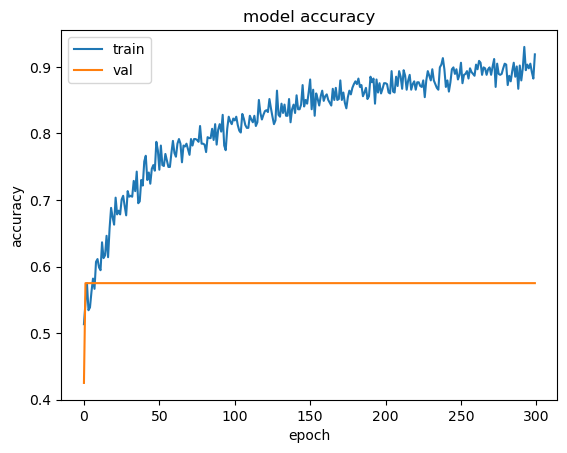

In [92]:
plot_acc(history)

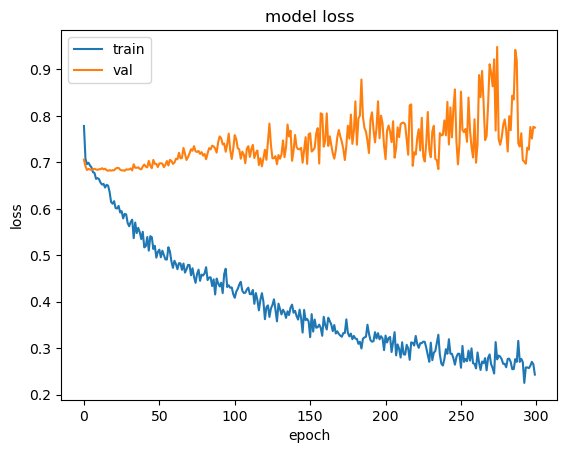

In [93]:
plot_loss(history)

In [90]:
new_model.evaluate(X_test, Y_test)

6/6 [==============================] - 0s 17ms/step - loss: 0.8024 - accuracy: 0.5538


[0.8024039268493652, 0.5537634491920471]

### Conclusion
The performance of the model was poor, we believe it was due to the limited amount of data we had. Deep Learning Models requires large amount of data in order to achive significant performance. The preprocessing step of the model is also important, we think we may have to do more data preprocessing before inputing our data into the model.